# Task 3: Build a Neural Network

## Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime

## Load Data

In [3]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

data_path = os.path.join(DATA_DIR, "Stock Prices Data Set.csv")
data = pd.read_csv(data_path)

In [4]:
print("Stock Prices Data Shape:", data.shape)

Stock Prices Data Shape: (497472, 7)


In [5]:
print("Stock Prices Data Preview:")
display(data.head())

Stock Prices Data Preview:


,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preprocessing

In [6]:
# Convert and sort by date
data["date"] = pd.to_datetime(data["date"])
data.sort_values(by=["symbol", "date"], inplace=True)

In [7]:
# Remove duplicates if any
data.drop_duplicates(subset=["symbol", "date"], inplace=True)

In [8]:
# Encode target label
label_encoder = LabelEncoder()
data["symbol_encoded"] = label_encoder.fit_transform(data["symbol"])

In [9]:
# Define features and target
features = ["open", "high", "low", "close", "volume"]
target = "symbol_encoded"

In [10]:
# Remove rows with missing or zero volume (if any)
data = data.dropna(subset=features)
data = data[data["volume"] > 0]

In [11]:
# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [12]:
# Drop rows with NaN or inf after normalization
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [13]:
# Create sequences per stock symbol
def create_symbol_sequences(df, time_steps=5):
    X, y = [], []
    symbols = df["symbol"].unique()
    for symbol in symbols:
        temp = df[df["symbol"] == symbol]
        values = temp[features].values.astype(np.float32)
        labels = temp[target].values
        if len(values) <= time_steps:
            continue
        for i in range(len(values) - time_steps):
            X.append(values[i:i+time_steps])
            y.append(labels[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 5
X_seq, y_seq = create_symbol_sequences(data, time_steps=TIME_STEPS)

In [14]:
print(f"Total sequences created: {X_seq.shape[0]}")

Total sequences created: 494936


In [15]:
print(f"Input shape: {X_seq.shape}, Output shape: {y_seq.shape}")

Input shape: (494936, 5, 5), Output shape: (494936,)


## Split dataset

In [16]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

## Build Neural Network Model

In [ ]:
# Build Neural Network Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_seq)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Callbacks (gunakan .h5 untuk menghindari error)
now = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = f"best_model_{now}.h5"
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

## Train Model

In [19]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
6183/6187 [============================>.] - ETA: 0s - loss: 4.8633 - accuracy: 0.0267
Epoch 1: val_accuracy improved from -inf to 0.06867, saving model to best_model_20250406-120634.h5
6187/6187 [==============================] - 87s 13ms/step - loss: 4.8629 - accuracy: 0.0267 - val_loss: 4.2086 - val_accuracy: 0.0687
Epoch 2/30
  10/6187 [..............................] - ETA: 1:17 - loss: 4.3234 - accuracy: 0.0500

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6183/6187 [============================>.] - ETA: 0s - loss: 4.1142 - accuracy: 0.0732
Epoch 2: val_accuracy improved from 0.06867 to 0.08204, saving model to best_model_20250406-120634.h5
6187/6187 [==============================] - 83s 13ms/step - loss: 4.1141 - accuracy: 0.0732 - val_loss: 4.0033 - val_accuracy: 0.0820
Epoch 3/30
6183/6187 [============================>.] - ETA: 0s - loss: 3.9888 - accuracy: 0.0842
Epoch 3: val_accuracy improved from 0.08204 to 0.09775, saving model to best_model_20250406-120634.h5
6187/6187 [==============================] - 83s 13ms/step - loss: 3.9888 - accuracy: 0.0842 - val_loss: 3.8712 - val_accuracy: 0.0977
Epoch 4/30
6185/6187 [============================>.] - ETA: 0s - loss: 3.9244 - accuracy: 0.0898
Epoch 4: val_accuracy improved from 0.09775 to 0.10471, saving model to best_model_20250406-120634.h5
6187/6187 [==============================] - 87s 14ms/step - loss: 3.9243 - accuracy: 0.0898 - val_loss: 3.8200 - val_accuracy: 0.1047
Epoch 

## Evaluate Model

In [20]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.1282


## Classification Report

In [21]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

3094/3094 [==============================] - 12s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.07      0.01      0.02       200
         AAL       0.00      0.00      0.00       201
         AAP       0.08      0.22      0.11       200
        AAPL       0.88      0.79      0.83       200
        ABBV       0.07      0.02      0.04       201
         ABC       0.00      0.00      0.00       200
         ABT       0.11      0.01      0.02       200
         ACN       0.00      0.00      0.00       200
        ADBE       0.00      0.00      0.00       201
         ADI       0.09      0.01      0.02       200
         ADM       0.04      0.14      0.06       200
         ADP       0.05      0.18      0.08       200
         ADS       0.44      0.17      0.25       201
        ADSK       0.00      0.00      0.00       201
         AEE       0.04      0.05      0.04       201
         AEP       0.10      0.04      0.06       200

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

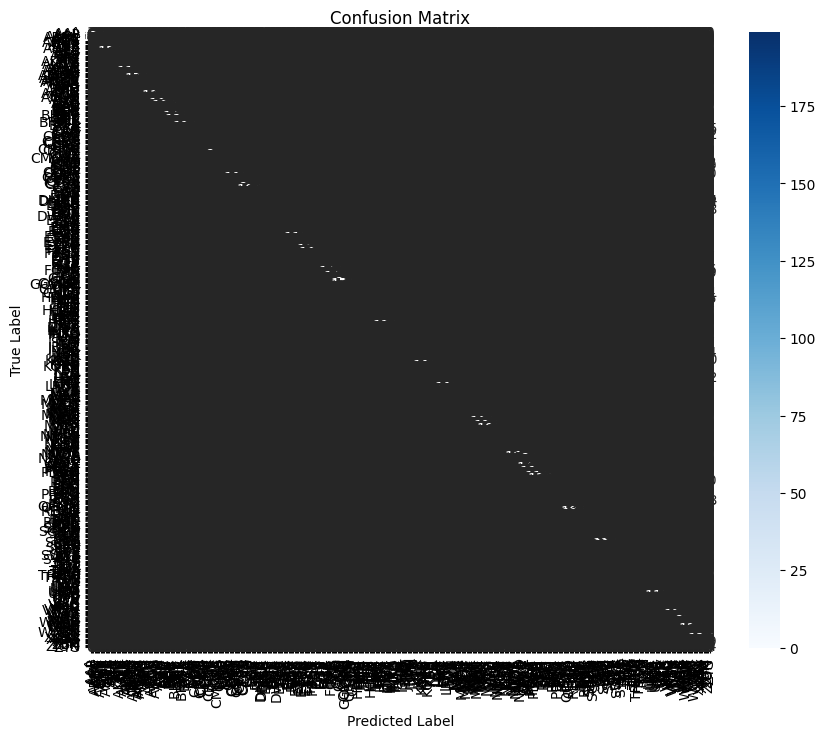

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Plot Training History

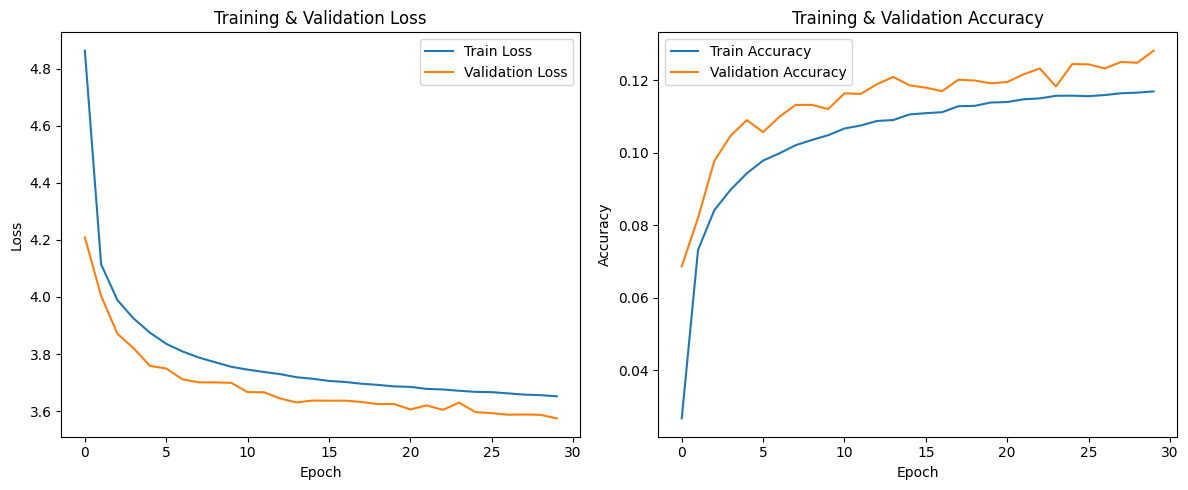

In [23]:
# Plot Training History
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()